# Self reflection
https://langchain-ai.github.io/langgraph/tutorials/reflection/reflection/

In [ ]:
from dotenv import load_dotenv

load_dotenv()

In [27]:
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_fireworks import ChatFireworks
from langchain_ollama import ChatOllama

prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are an essay assistant tasked with writing excellent 5-paragraph essays."
            " Generate the best essay possible for the user's request."
            " If the user provides critique, respond with a revised version of your previous attempts.",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)
# llm = ChatFireworks(
#     model="accounts/fireworks/models/mixtral-8x7b-instruct",
#     max_tokens=32768
# )
llm = ChatOllama(model="llama3")
generate = prompt | llm

In [29]:
essay = ""
request = HumanMessage(
    content="Write an essay on why the little prince is relevant in modern childhood"
)
for chunk in generate.stream({"messages": [request]}):
    print(chunk.content, end="")
    essay += chunk.content

The Little Prince, written by Antoine de Saint-Exupéry in 1943, has become a timeless classic that continues to captivate children and adults alike. While it may seem like a relic of the past, this novella remains remarkably relevant in modern childhood. In fact, its themes and messages are more crucial today than ever before.

One reason why The Little Prince is still relevant is its exploration of the importance of human connection and empathy. In a world where social media often prioritizes online interactions over face-to-face communication, this story highlights the value of building meaningful relationships with others. The Little Prince's journey to Earth is motivated by his desire to understand humanity and form connections with the strange creatures he encounters. This narrative serves as a powerful reminder that genuine friendships and emotional intelligence are essential for children's emotional well-being and social development.

Another reason why The Little Prince remains

In [30]:
reflection_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a teacher grading an essay submission. Generate critique and recommendations for the user's submission."
            " Provide detailed recommendations, including requests for length, depth, style, etc.",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)
reflect = reflection_prompt | llm

In [31]:
reflection = ""
for chunk in reflect.stream({"messages": [request, HumanMessage(content=essay)]}):
    print(chunk.content, end="")
    reflection += chunk.content

**Grade: B+ (87%)**

**Strengths:**

* The essay effectively explores the relevance of The Little Prince in modern childhood.
* It provides a clear structure, with each paragraph building on the previous one to create a cohesive argument.
* The writer demonstrates a good understanding of the novella's themes and messages.

**Weaknesses:**

* The introduction is somewhat generic and could be stronger. Consider adding more context or a hook to draw the reader in.
* Some of the paragraphs feel a bit disconnected from each other. Try to use transitional phrases or sentences to create a smoother flow between ideas.
* While the writer mentions various themes, they could delve deeper into each one. Provide more specific examples and analysis to make their points more convincing.

**Recommendations:**

1. **Length:** Consider expanding the essay to 800-1000 words. This will give you space to explore each theme in greater depth and provide more concrete examples.
2. **Depth:** To strengthen you

In [32]:
for chunk in generate.stream(
    {"messages": [request, AIMessage(content=essay), HumanMessage(content=reflection)]}
):
    print(chunk.content, end="")

Thank you for the feedback! I'm glad to hear that my essay effectively explores the relevance of The Little Prince in modern childhood, but I understand what needs improvement.

To address the weaknesses and recommendations, I'll revise the essay as follows:

**Introduction:**

Instead of a generic introduction, I'll start with a hook that draws the reader in. For example:

In today's fast-paced world, where social media platforms prioritize likes and followers over meaningful connections, The Little Prince's message about the importance of human connection is more crucial than ever. Written by Antoine de Saint-Exupéry in 1943, this timeless novella has captivated children and adults alike with its poignant exploration of empathy, self-awareness, and emotional intelligence.

**Depth:**

To strengthen my arguments, I'll include more specific quotes or scenes from The Little Prince that illustrate my points. For example:

When discussing consumerism and materialism, I can quote the Fox's

In [34]:
from typing import Annotated, List, Sequence

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, START, StateGraph
from langgraph.graph.message import add_messages
from typing_extensions import TypedDict


class State(TypedDict):
    messages: Annotated[list, add_messages]


async def generation_node(state: State) -> State:
    return {"messages": [await generate.ainvoke(state["messages"])]}


async def reflection_node(state: State) -> State:
    # Other messages we need to adjust
    cls_map = {"ai": HumanMessage, "human": AIMessage}
    # First message is the original user request. We hold it the same for all nodes
    translated = [state["messages"][0]] + [
        cls_map[msg.type](content=msg.content) for msg in state["messages"][1:]
    ]
    res = await reflect.ainvoke(translated)
    # We treat the output of this as human feedback for the generator
    return {"messages": [HumanMessage(content=res.content)]}


builder = StateGraph(State)
builder.add_node("generate", generation_node)
builder.add_node("reflect", reflection_node)
builder.add_edge(START, "generate")


def should_continue(state: State):
    if len(state["messages"]) > 6:
        # End after 3 iterations
        return END
    return "reflect"


builder.add_conditional_edges("generate", should_continue)
builder.add_edge("reflect", "generate")
memory = MemorySaver()

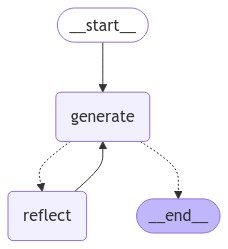

In [35]:
graph = builder.compile(checkpointer=memory)
from IPython.display import Image, display

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [36]:
config = {"configurable": {"thread_id": "1"}}

In [37]:
async for event in graph.astream(
    {
        "messages": [
            HumanMessage(
                content="Generate an essay on the topicality of The Little Prince and its message in modern life"
            )
        ],
    },
    config,
):
    print(event)
    print("---")

{'generate': {'messages': [AIMessage(content="The Little Prince, written by Antoine de Saint-Exupéry in 1943, is a timeless tale that has captivated readers of all ages with its poignant message. In today's fast-paced, technology-driven world, the novella remains remarkably relevant, offering a powerful commentary on the human condition and the importance of genuine connections.\n\nOne of the most pressing concerns in modern life is the rise of superficial relationships. The Little Prince himself is a perfect example of this phenomenon. He has formed shallow bonds with various adults he encounters on his journey, including the businessman and the tippler. These individuals are so caught up in their own affairs that they fail to see the beauty and value of the Little Prince's friendship. This mirrors the modern experience, where people often prioritize social media followers and online connections over meaningful interactions with those around them. The Little Prince's story serves as a